### SUM project

#### Comparing areas for inplementing New Shared Mobility (NSM) service
For comparing two Krakow areas, Skotniki and Bronowice Wielkie, we evaluate such indicators:
- decrease in waiting time for public transport
- attractiveness of NSM
- probability of choosing NSM

#### Perform simulations:
For each area generate the sample of requests, containing: origin, destination and time of the request (O, D, T), evaluate utilities for two trip options:
<br>
<br><b>The public transport option (PT):</b>
<ul>
    <li>using the OTP API define the PT routes for each request in the sample (PT OD)</li>
    <li>calculate the utility of each trip (u PT OD)</li>
</ul>
<b>The SUM option:</b>
<ul>
    <li>calculate the utility of the trip from origin to hub (u SUM OH)</li>
    <li>with OTP API define the PT routes for each request from the hub to destination (PT HD)</li>
    <li>calculate the utility of the trip from hub to destination (u PT HD)</li>
    <li>calculate the total utility of the SUM option (u SUM OD)</li>
</ul>
<b>Results:</b>
<br> run function simulate() N times
<ul>
    <li>the results are stored in the tuple with the 1st element as a dictionary with area name as the key and the dataframe as a value
    <br>dataframe contains mean values for such parameters:
        <ul>
            <li>waiting times for the PT OD and PT HD</li>
            <li>utilities for PT OD and SUM OD</li>
            <li>probability of choosing SUM service</li>
            <li>ex. {'Skotniki': tw_PT_OD, tw_PT_HD, u_PT_OD, u_PT_HD, u_SUM_OD, p_SUM}</li>
        </ul>
    </li>
    <li>the 2nd element of the tuple is a dictionary, where area name is the key and dataframe is the value
        <br>dataframe contains the results of the last iteration
        <ul>
            <li>ex. {'Skotniki': origin_x, origin_y, destination_x, destination_y, treq, u_PT_OD, origin, hub, dist, ttrav, tarr, u, u_SUM_OD, p_SUM}</li>
        </ul>
    </li>
<ul>

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox

from shapely.geometry import Point

import ExMAS.utils
from ExMAS.utils import inData
from src import functions as fncs

#### Prepare the input data

Set up the OTP API and define the parameters (such as average_speed, ticket_price, etc.) in the default_SUM.json file

In [2]:
OTP_API = "http://localhost:8080/otp/routers/default/plan"
params = ExMAS.utils.get_config('data/configs/default_SUM.json')

When first time running the code, download and save the city graph

In [3]:
# inData = ExMAS.utils.download_G(inData, params)
# ExMAS.utils.save_G(inData, params)

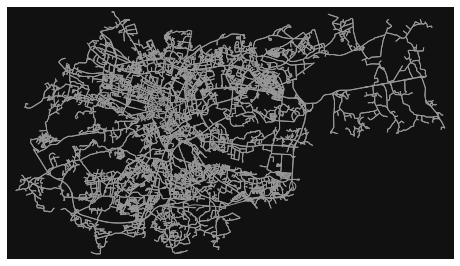

In [4]:
inData = ExMAS.utils.load_G(inData, params, stats=True)
fig, ax = ox.plot_graph(inData.G, node_size=0)

Read the files with data: city zones and their centroids

In [5]:
gdf_zones = gpd.read_file('data/krk.geojson')
gdf_centroid = gpd.read_file('data/krk_centroid.geojson')

Read SUM areas and transform the coordinate system to EPSG:4326

<Axes: >

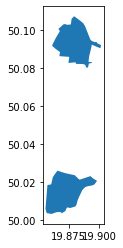

In [6]:
gdf_areas = gpd.read_file('data/sum_areas/sum_areas_B+S.shp')
gdf_areas = gdf_areas.rename(columns={"nazwa": "name"})
gdf_areas = gdf_areas.to_crs(4326)
gdf_areas.plot()

In [7]:
gdf_areas

,name,geometry
0,Bronowice Wielkie,"POLYGON ((19.87805 50.08284, 19.87469 50.08260..."
1,Skotniki,"POLYGON ((19.88842 50.01723, 19.88734 50.01662..."


Read ODMs, clean the data and calculate the "probabilities" for destinations

In [8]:
od = pd.read_excel('data/krk_ODM.xlsx', skiprows=[1, 2])
od.rename(columns = {'464 x 464' : 'zone_NO', 'Unnamed: 2': 'sum'}, inplace = True)
od.drop(od.filter(regex="Unname"), axis=1, inplace=True)
od.reset_index(drop=True, inplace=True)
od[0:] = od[:].astype(float)
od['zone_NO'] = od['zone_NO'].astype(int)
# filter OD zone number to match city zones and recalculate sum for origins
od = od.loc[od['zone_NO'].isin(gdf_zones['NO']), ['zone_NO', 'sum'] + gdf_zones['NO'].to_list()]
od['sum'] = od.loc[:, 1:].sum(axis=1)
# calculate "probabilities" for each origin point
od_probs = pd.concat([od['zone_NO'], 
            od.loc[:, 'sum':].astype('float64').divide(od.loc[:, 'sum'].astype('float64'), axis=0)], axis=1)

Read the population distribution of the city, clean the data

In [9]:
df_demo = pd.read_csv('data/krk_demographic.csv', index_col=0)
df_demo = df_demo.rename(columns={"adr_pelny": "address", "ogolem": "total" })
filter = ['STAREGO DĘBU' in i for i in df_demo['address']]
df_demo.loc[filter, 'x'], df_demo.loc[filter, 'y'] = 19.872702, 50.100578
# assign zone number to each address point
df_demo['zone_NO'] = df_demo.apply(lambda row: 
                    fncs.find_containing_polygon(Point(row['x'], row['y']), gdf_zones), axis=1)
# remove the trips with nan zone
df_demo.dropna(subset='zone_NO', inplace=True, ignore_index=True)

Define hub locations for each area

In [10]:
hubs = {"Bronowice Wielkie": (19.88192, 50.08179), "Skotniki": (19.88948, 50.01844)}

#### Run simulations

In [11]:
N = 1
results = fncs.simulate(gdf_areas, df_demo, gdf_centroid, od, od_probs, hubs, inData, params, OTP_API, N)

Save [results](https://github.com/anniutina/SUM/tree/main/results)

In [ ]:
# results[1]["Bronowice Wielkie"].to_csv("results/bronowice_" + str(N) + ".csv")
# results[1]["Skotniki"].to_csv("results/skotniki_" + str(N) + ".csv")

Example of the results of 1 iteration for the Bronowice Wielkie area

In [22]:
# mean values of the selected parameters
results[0]['Bronowice Wielkie']

,tw_PT_OD,tw_PT_HD,u_PT_OD,u_PT_HD,u_SUM_OD,p_SUM
0,110.917226,38.879195,13.295389,9.388012,15.590782,0.35291


In [23]:
# assessed parameters for the selected sample
df_SUM_bronowice = results[1]["Bronowice Wielkie"]
df_SUM_bronowice.head(2)

,origin_x,origin_y,destination_x,destination_y,treq,u_PT_OD,origin,hub,dist,ttrav,tarr,u,u_SUM_OD,p_SUM
0,19.878573,50.085218,19.885469,50.097415,2024-03-28 08:07:07,10.629784,2377013550,1786358199,728,121.333333,2024-03-28 08:09:08,1.456,10.074087,0.635456
1,19.885837,50.085314,19.883808,50.003198,2024-03-28 08:00:37,23.142264,4263449095,1786358199,1897,316.166667,2024-03-28 08:05:53,3.794,26.650562,0.029077


#### ExMAS for SUM areas

Bronowice Wielkie area

In [24]:
# Define requests
bronowice_reqs = results[1]["Bronowice Wielkie"][["origin_x", "origin_y", 
                                                "destination_x", "destination_y", "treq"]]
bronowice_reqs.head(5)

,origin_x,origin_y,destination_x,destination_y,treq
0,19.878573,50.085218,19.885469,50.097415,2024-03-28 08:07:07
1,19.885837,50.085314,19.883808,50.003198,2024-03-28 08:00:37
2,19.882007,50.093676,19.896750,50.092024,2024-03-28 07:55:24
3,19.882770,50.085869,19.888638,50.085473,2024-03-28 08:06:06
4,19.886570,50.085111,19.918898,50.098454,2024-03-28 08:07:55


In [25]:
# Run ExMAS for Bronowice Wielkie area
fncs.run_ExMAS(bronowice_reqs, inData, params, hubs["Bronowice Wielkie"], degree=8)

18-06-24 15:12:03-INFO-Initializing pairwise trip shareability between 447 and 447 trips.
18-06-24 15:12:04-INFO-creating combinations
18-06-24 15:12:04-INFO-199362	 nR*(nR-1)
18-06-24 15:12:06-INFO-Reduction of feasible pairs by 98.66%
18-06-24 15:12:06-INFO-Degree 2 	Completed
18-06-24 15:12:06-INFO-trips to extend at degree 2 : 5460
18-06-24 15:12:16-INFO-At degree 2 feasible extensions found out of 7401 searched
18-06-24 15:12:16-INFO-Degree 3 	Completed
18-06-24 15:12:16-INFO-trips to extend at degree 3 : 7401
18-06-24 15:12:39-INFO-At degree 3 feasible extensions found out of 10545 searched
18-06-24 15:12:39-INFO-Degree 4 	Completed
18-06-24 15:12:39-INFO-trips to extend at degree 4 : 10545
18-06-24 15:13:10-INFO-At degree 4 feasible extensions found out of 9882 searched
18-06-24 15:13:10-INFO-Degree 5 	Completed
18-06-24 15:13:10-INFO-trips to extend at degree 5 : 9882
18-06-24 15:13:38-INFO-At degree 5 feasible extensions found out of 5266 searched
18-06-24 15:13:38-INFO-Degree

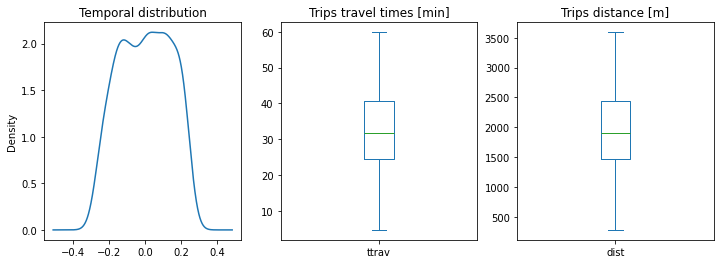

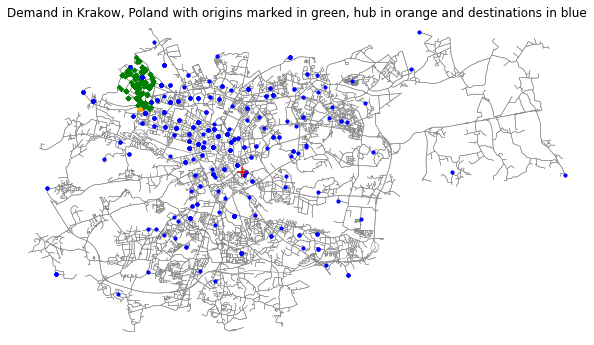

In [26]:
ExMAS.utils.plot_demand(inData, params)

Skotniki area

In [27]:
# Define requests
skotniki_reqs = results[1]["Skotniki"][["origin_x", "origin_y", 
                                        "destination_x", "destination_y", "treq"]].reset_index(drop=True)
skotniki_reqs.head(5)

,origin_x,origin_y,destination_x,destination_y,treq
0,19.887605,50.017524,19.929784,50.063029,2024-03-28 08:06:16
1,19.870841,50.019940,19.900280,50.075934,2024-03-28 07:46:43
2,19.882427,50.013276,19.919770,50.069342,2024-03-28 07:56:23
3,19.882267,50.017870,19.900957,50.019553,2024-03-28 08:05:33
4,19.881463,50.016740,19.969009,50.019272,2024-03-28 08:12:28


In [28]:
# Run ExMAS for Skotniki area
fncs.run_ExMAS(skotniki_reqs, inData, params, hubs["Skotniki"], degree=8)

18-06-24 15:16:44-INFO-Initializing pairwise trip shareability between 172 and 172 trips.
18-06-24 15:16:44-INFO-creating combinations
18-06-24 15:16:44-INFO-29412	 nR*(nR-1)
18-06-24 15:16:44-INFO-Reduction of feasible pairs by 98.83%
18-06-24 15:16:44-INFO-Degree 2 	Completed
18-06-24 15:16:44-INFO-trips to extend at degree 2 : 734
18-06-24 15:16:45-INFO-At degree 2 feasible extensions found out of 146 searched
18-06-24 15:16:45-INFO-Degree 3 	Completed
18-06-24 15:16:45-INFO-trips to extend at degree 3 : 146
18-06-24 15:16:45-INFO-At degree 3 feasible extensions found out of 16 searched
18-06-24 15:16:45-INFO-Degree 4 	Completed
18-06-24 15:16:45-INFO-trips to extend at degree 4 : 16
18-06-24 15:16:45-INFO-At degree 4 feasible extensions found out of 0 searched
18-06-24 15:16:45-INFO-Degree 5 	Completed
18-06-24 15:16:45-INFO-No more trips to exted at degree 5
18-06-24 15:16:45-INFO-Matching 172 trips to 1068 rides in order to min u_veh
18-06-24 15:16:45-INFO-Problem solution: Optim

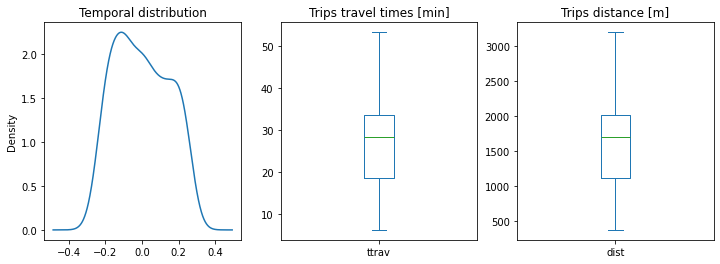

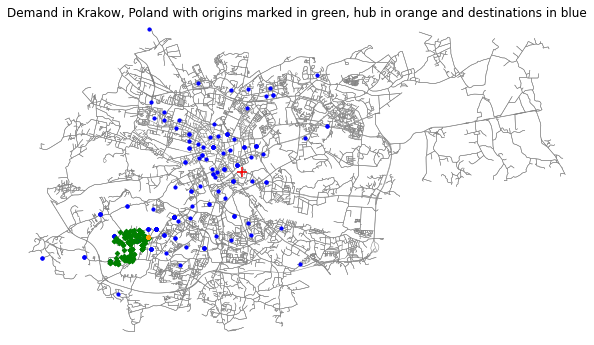

In [29]:
ExMAS.utils.plot_demand(inData, params)